In [11]:
import sys
sys.path.append('..')

In [29]:
import os
from typing import List, Tuple
import random
import time

In [13]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import cv2 as cv

In [14]:
from src.data_access.data_transformations import EntryTransformation, \
    DataTransformationChain, DataStandardisation, DataAugmentation
from src.data_access.folds_generation import FoldsGenerator
from src.primitives.data_access import FoldsGeneratorSpecs, RandomSplitSpecs, \
    RotationBasedClassSplit, DataSetExampleBatch
from src.visualisation.plotting import make_column_plot
from src.config import DATASET_PATH, CLASS_MAPPINGS, BACKGROUNDS_DIR_NAME
from src.primitives.images import ImageSize
from src.utils.images import load_image

In [15]:
TO_SHOW_FROM_SPLIT = 16

In [16]:
def adjust_batch_to_show(batch: DataSetExampleBatch
                         ) -> List[Tuple[np.ndarray, np.ndarray]]:
    images, masks = batch
    return [
        (image, mask)  for image, mask in zip(images, masks)
    ]

In [17]:
random_split_specs = RandomSplitSpecs(
    classes=set(CLASS_MAPPINGS.keys()),
    splits_number=1,
    training_samples_factor=0.8
)

In [18]:
training_angles = {
    "adapter": {0, 30, 90},
    "bottle": {0, 60},
    "box": {0, 60},
    "clamp": {0, 60},
    "drill": {0, 30, 90},
    "duck": {0, 60}
}

test_angles = {
    "adapter": {60},
    "bottle": {30},
    "box": {30},
    "clamp": {30},
    "drill": {60},
    "duck": {30}
}


rotation_based_class_split = RotationBasedClassSplit(
    training_angles=training_angles,
    test_angles=test_angles
)

In [19]:
folds_generator_specs = FoldsGeneratorSpecs(
    random_split_specs=random_split_specs,
    rotation_based_splits=[rotation_based_class_split]
)

In [20]:
genarator = FoldsGenerator(
    dataset_path=DATASET_PATH,
    generator_specs=folds_generator_specs
)

In [21]:
backgrounds_wildrcard = os.path.join(DATASET_PATH, BACKGROUNDS_DIR_NAME, "*.jpg")
backgrounds_paths = glob(backgrounds_wildrcard)
backgrounds = [load_image(path, cv.COLOR_BGR2RGB) for path in backgrounds_paths]

## Augmentation usage example

In [22]:
from albumentations import (
    HorizontalFlip, VerticalFlip, Blur, RandomGamma, Rotate, ShiftScaleRotate,
    OpticalDistortion, GridDistortion, ElasticTransform, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, MotionBlur, GaussianBlur,
    CLAHE, ChannelShuffle, ToGray, JpegCompression, Cutout, Downscale,
    FancyPCA, Posterize, Equalize, ISONoise, RandomFog
)

augmentations = [
    HorizontalFlip(always_apply=False, p=0.15),
    VerticalFlip(always_apply=False, p=0.15),
    Blur(blur_limit=16, always_apply=False, p=0.15),
    RandomGamma(gamma_limit=(60, 140), always_apply=False, p=0.1),
    Rotate(limit=35, always_apply=False, p=0.15),
    ShiftScaleRotate(rotate_limit=35, always_apply=False, p=0.1),
    OpticalDistortion(distort_limit=1.0, shift_limit=1.0, always_apply=False, p=0.1),
    GridDistortion(always_apply=False, p=0.1),
    ElasticTransform(always_apply=False, p=0.1),
    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.1),
    RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.1),
    RandomBrightness(limit=0.3, always_apply=False, p=0.1),
    RandomContrast(limit=0.3, always_apply=False, p=0.1),
    MotionBlur(blur_limit=7, always_apply=False, p=0.1),
    GaussianBlur(blur_limit=7, always_apply=False, p=0.1),
    CLAHE(always_apply=False, p=0.1),
    ChannelShuffle(always_apply=False, p=0.05),
    ToGray(always_apply=False, p=0.5),
    JpegCompression(quality_lower=10, quality_upper=100, always_apply=False, p=0.15),
    Cutout(num_holes=32, max_h_size=12, max_w_size=12, always_apply=False, p=0.07),
    Downscale(always_apply=False, p=0.2),
    FancyPCA(alpha=0.4, always_apply=False, p=0.1),
    Posterize(num_bits=4, always_apply=False, p=0.03),
    Equalize(always_apply=False, p=0.03),
    ISONoise(color_shift=(0.1, 0.5), always_apply=False, p=0.07),
    RandomFog(always_apply=False, p=0.03),
]

In [28]:
target_size_element = ImageSize(
    height=480,
    width=640
)

entry_transformation = EntryTransformation(
    class_mapping=CLASS_MAPPINGS,
    target_size=target_size_element,
    backgrounds=backgrounds
)

data_augmentations = [
    DataAugmentation(
        transformations=augmentations,
        global_application_probab=0.7   
    ),
#     DataStandardisation() # Commented out as it harden visualisation 
]

transformation_chain = DataTransformationChain(
    entry_transformation=entry_transformation,
    augmentations=data_augmentations
)

Batch transformation for 16 el. took 3.0248188972473145


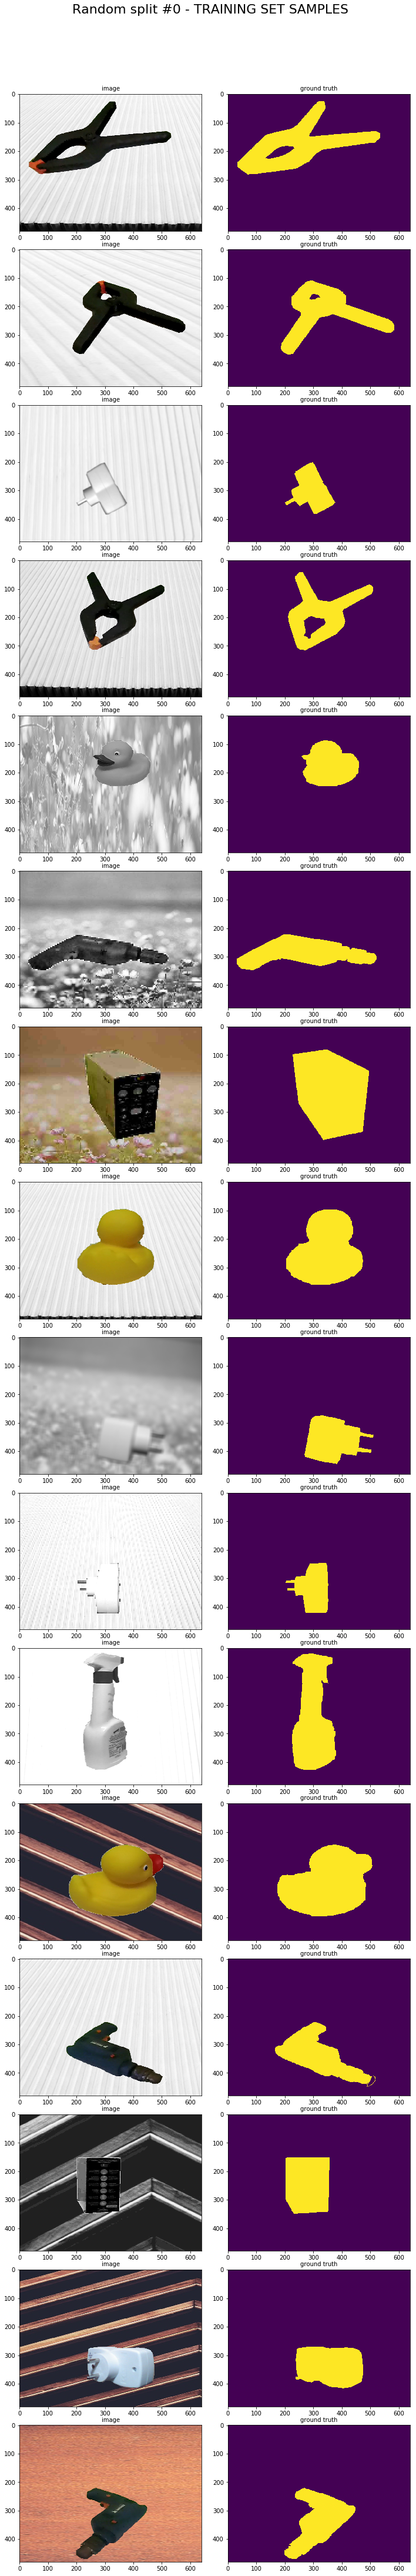

Batch transformation for 16 el. took 2.530282735824585


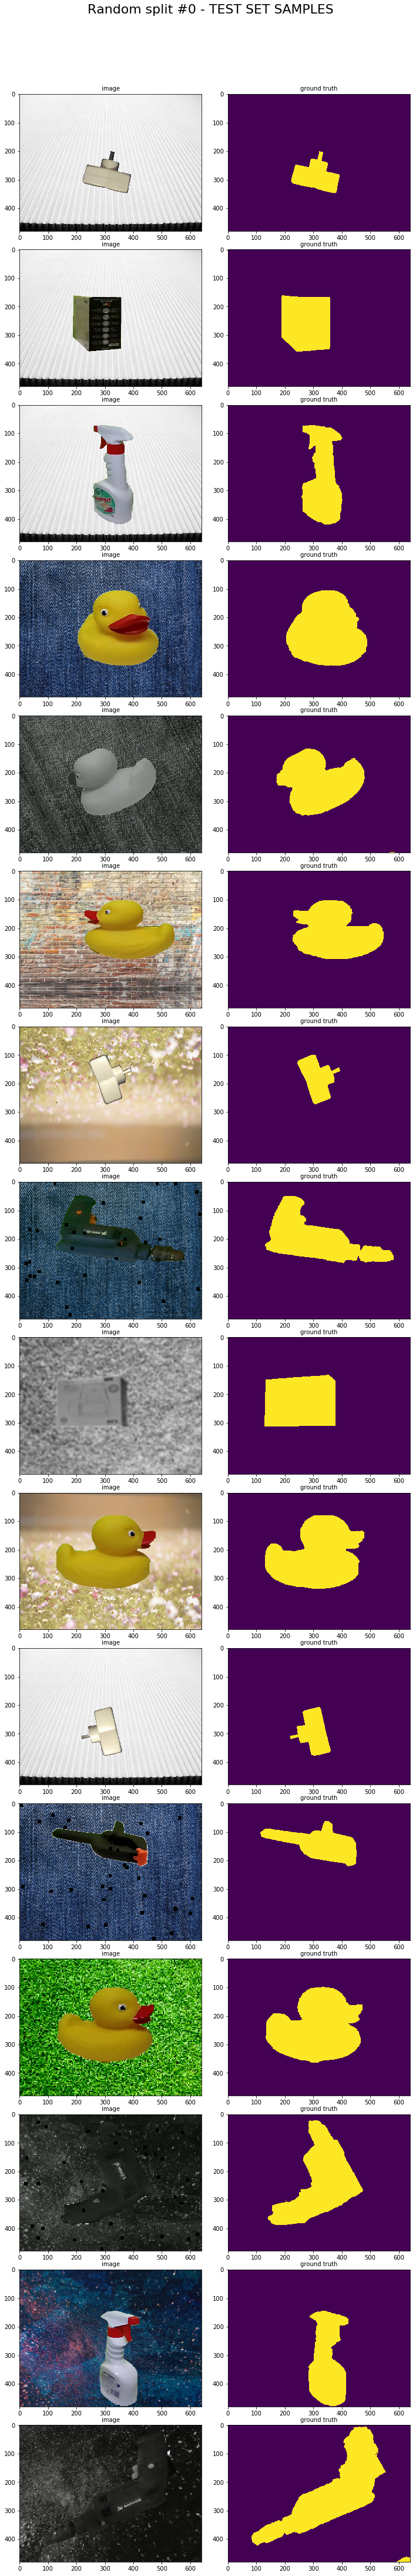

Batch transformation for 16 el. took 2.838042736053467


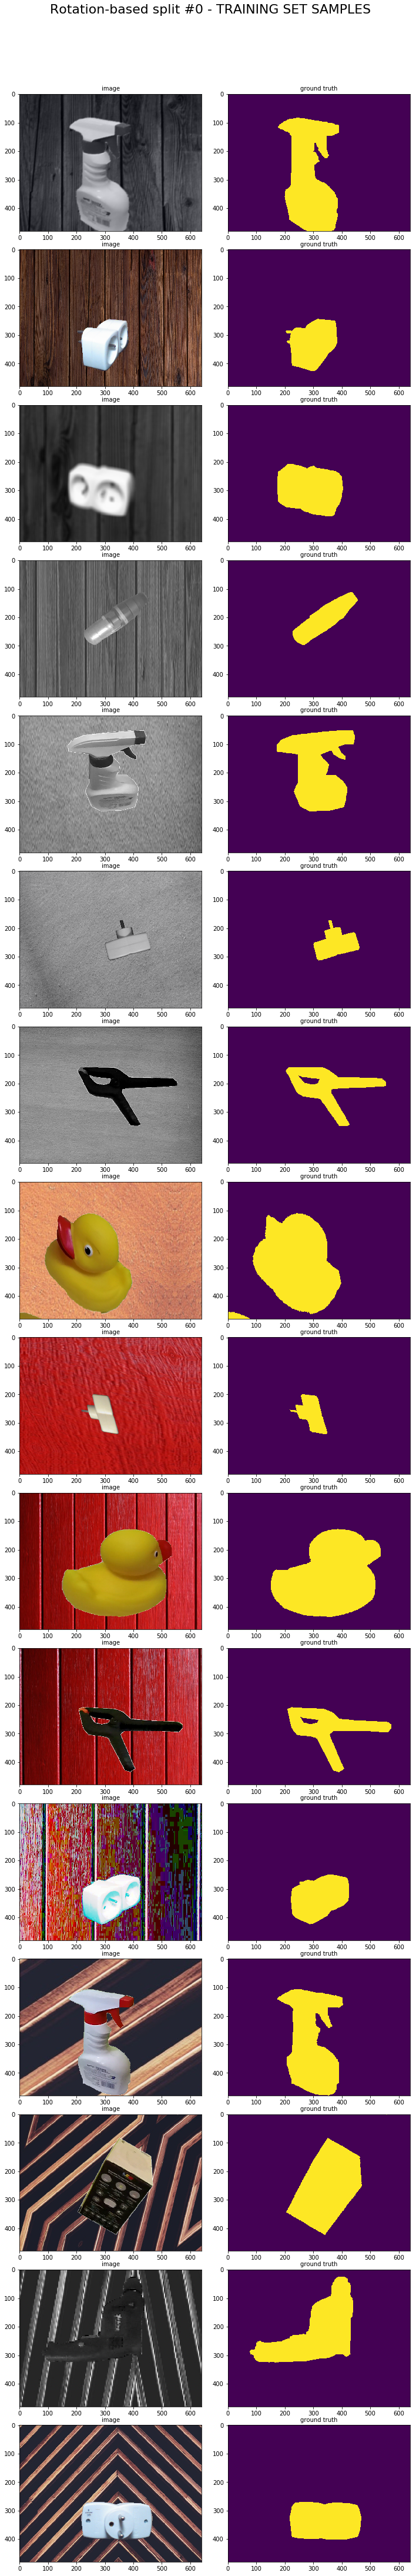

Batch transformation for 16 el. took 3.1480634212493896


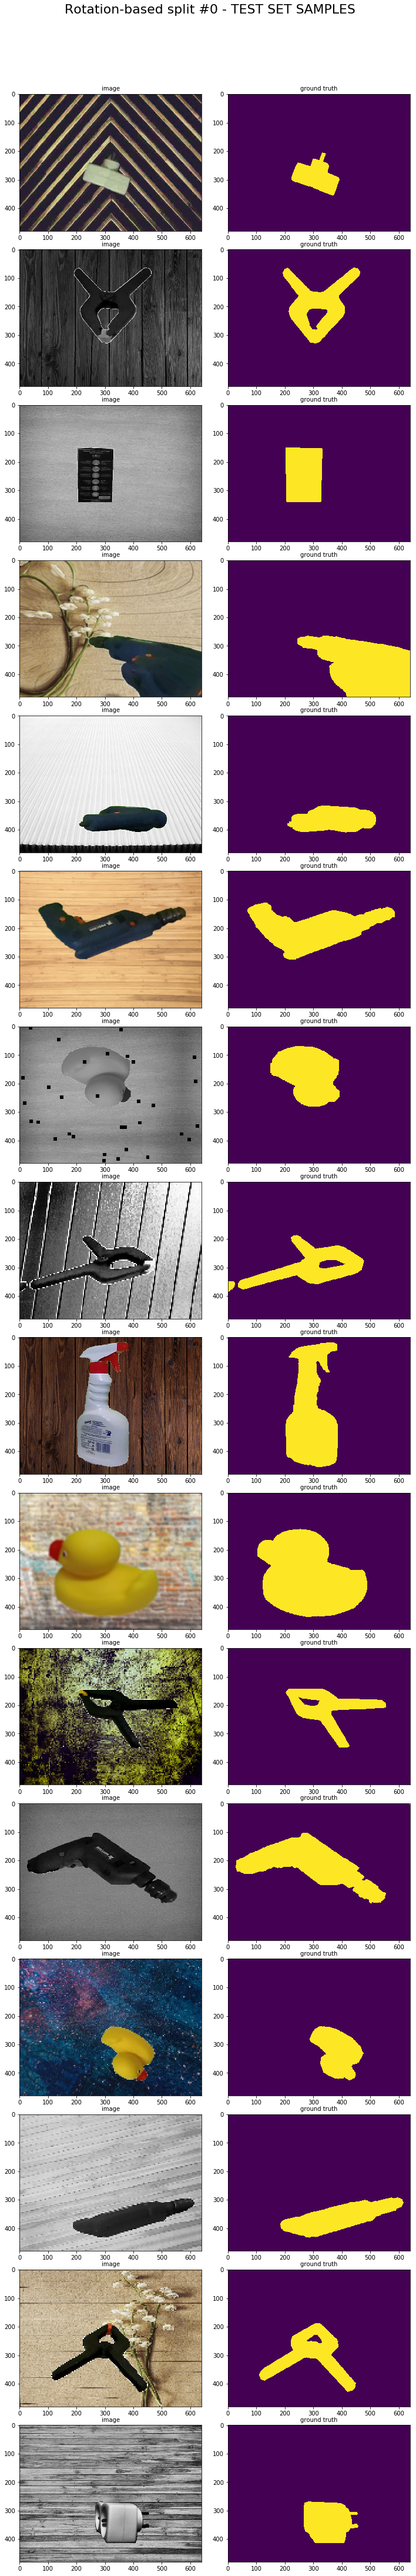

In [30]:
COLUMNS = ['image', 'ground truth']

for split in genarator.generate_folds():
    training_set_examples = split.training_set.examples
    random.shuffle(training_set_examples)
    start_time = time.time()
    training_set_examples = transformation_chain.transform_batch(
        training_set_examples[:TO_SHOW_FROM_SPLIT]
    )
    duration = time.time() - start_time
    print(f"Batch transformation for {TO_SHOW_FROM_SPLIT} el. took {duration}s")
    training_set_examples = adjust_batch_to_show(
        batch=training_set_examples
    )
    make_column_plot(
        title=f'{split.name} - TRAINING SET SAMPLES',
        column_names=COLUMNS,
        content=training_set_examples
    )
    plt.show()
    test_set_examples = split.test_set.examples
    random.shuffle(test_set_examples)
    start_time = time.time()
    test_set_examples = transformation_chain.transform_batch(
        test_set_examples[:TO_SHOW_FROM_SPLIT]
    )
    duration = time.time() - start_time
    print(f"Batch transformation for {TO_SHOW_FROM_SPLIT} el. took {duration}s")
    test_set_examples = adjust_batch_to_show(
        batch=test_set_examples
    )
    make_column_plot(
        title=f'{split.name} - TEST SET SAMPLES',
        column_names=COLUMNS,
        content=test_set_examples
    )
    plt.show()